In [1]:
import random
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')

import math
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from util import array2mat, mat2array
from analyse_util import figure_size, set_plt, set_Border

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random.seed(0)

# train_set = np.load('/lmh_data/data/sclab/sclab/train_dataset.npy', allow_pickle=True)
eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
preds = {
    'ALL': np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA/evaluate.npy', allow_pickle=True),
    'Astro': np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA_Astro/evaluate.npy', allow_pickle=True),
    'OPC': np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA_OPC/evaluate.npy', allow_pickle=True),
    'ODC': np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA_ODC/evaluate.npy', allow_pickle=True),
    'Astro_ODC': np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA_Astro_ODC/evaluate.npy', allow_pickle=True),
    'Astro_OPC': np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA_Astro_OPC/evaluate.npy', allow_pickle=True),
    'OPC_ODC': np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA_OPC_ODC/evaluate.npy', allow_pickle=True),
}

In [3]:
indices = []
for i in range(len(eval_set)):
    _hic = eval_set[i]['scHiC']['PDGFRA']
    if np.sum(np.triu(array2mat(_hic), k=1)) > 1:
        indices.append(i)
        
eval_set = eval_set[indices]
for key in preds.keys():
    preds[key] = preds[key][indices]

In [4]:
def cal_by_cell_type(cell_type, _preds):
    def _similarity(_array1, _array2):
        _array1, _array2 = array2mat(_array1).copy(), array2mat(_array2).copy()
        _array1[_array1<0] = 0
        _array1 = _array1 * 10
        _array1 = np.around(_array1)
        
#         np.fill_diagonal(_array1, np.diag(_array1)/5)
#         np.fill_diagonal(_array2, np.diag(_array2)/5)
        np.fill_diagonal(_array1, np.diag(_array1)/_array1.shape[0])
        np.fill_diagonal(_array2, np.diag(_array2)/_array2.shape[0])
#         np.fill_diagonal(_array1, np.diag(_array1)/(np.sum(np.diag(_array1))/np.sum(_array1-np.diag(_array1))))
#         np.fill_diagonal(_array2, np.diag(_array2)/(np.sum(np.diag(_array2))/np.sum(_array2-np.diag(_array2))))

        _array1, _array2 = mat2array(_array1), mat2array(_array2)

        dot_product = _array1.dot(_array2.T)
        norms = np.linalg.norm(_array1) * np.linalg.norm(_array2)
        similarity = dot_product / norms
        return similarity

    _values = []
    for i in range(len(_preds)):
        _pred = _preds[i]
        if eval_set[i]['cell_type'] != cell_type:
            continue
        _values.append(_similarity(_pred['predict'], eval_set[i]['scHiC']['PDGFRA']))

    return _values

In [5]:
plot_values = pd.DataFrame()
for cell_type in ['Astro', 'ODC', 'OPC']:
    for key in preds.keys():
        _values = pd.DataFrame(cal_by_cell_type(cell_type, preds[key]), columns=['score'])
        _values['cell_type'] = cell_type
        _values['model'] = key
        plot_values = pd.concat([plot_values, _values])
plot_values

,score,cell_type,model
0,0.880416,Astro,ALL
1,0.762694,Astro,ALL
2,0.835359,Astro,ALL
3,0.876421,Astro,ALL
4,0.992611,Astro,ALL
...,...,...,...
17,0.999288,OPC,OPC_ODC
18,0.996288,OPC,OPC_ODC
19,0.300942,OPC,OPC_ODC
20,0.908259,OPC,OPC_ODC


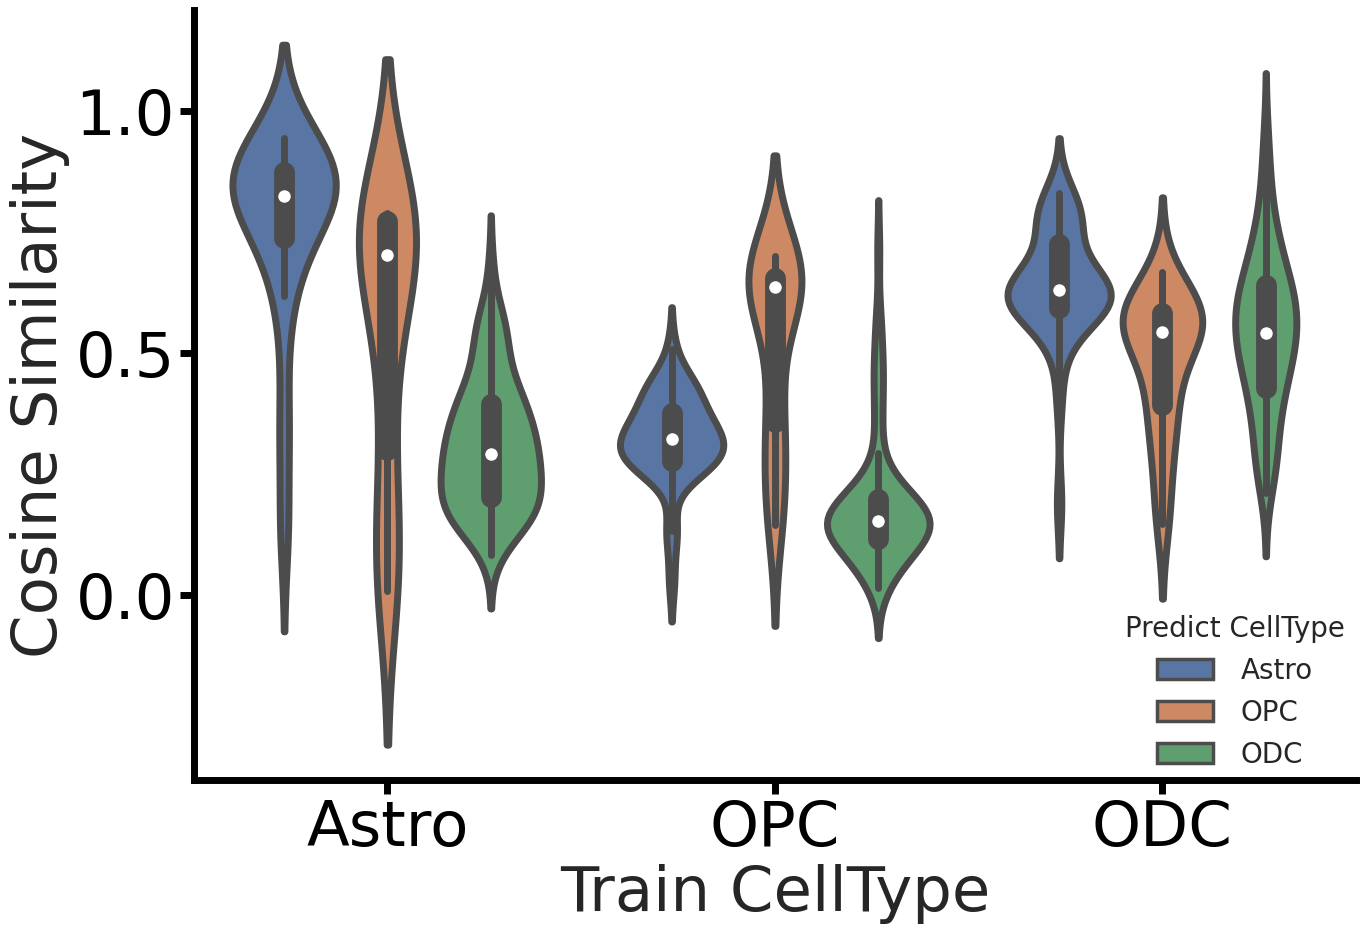

In [6]:
set_plt(figsize=(15, 10))
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

_cell_type = ['Astro', 'OPC', 'ODC']
_plot_values = plot_values[plot_values['model'].isin(_cell_type)]
ax = sns.violinplot(
    data=_plot_values, x='model', y='score', hue='cell_type', order=_cell_type, hue_order=_cell_type,
    linewidth=figure_size['very_small'])
# ax = sns.stripplot(data=_plot_values, x="model", y="score", hue='cell_type', linewidth=figure_size['very_small'])

# ax.set_xticklabels(labels=['Astro', 'ODC', 'OPC'])

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)

plt.legend(
    title='Predict CellType', title_fontsize=figure_size['middle'], fontsize=figure_size['middle'],
    facecolor='white', loc='lower right', framealpha=0, handletextpad=1, borderaxespad=0
).get_frame().set_linewidth(0.0)

plt.xlabel("Train CellType", fontsize=figure_size['ultra'])
plt.ylabel("Cosine Similarity", fontsize=figure_size['ultra'])
plt.savefig('/lmh_data/work/SEE/analyse/figure_file/PDGFRA DataGeneralization.pdf', format='pdf', bbox_inches='tight')
plt.show()

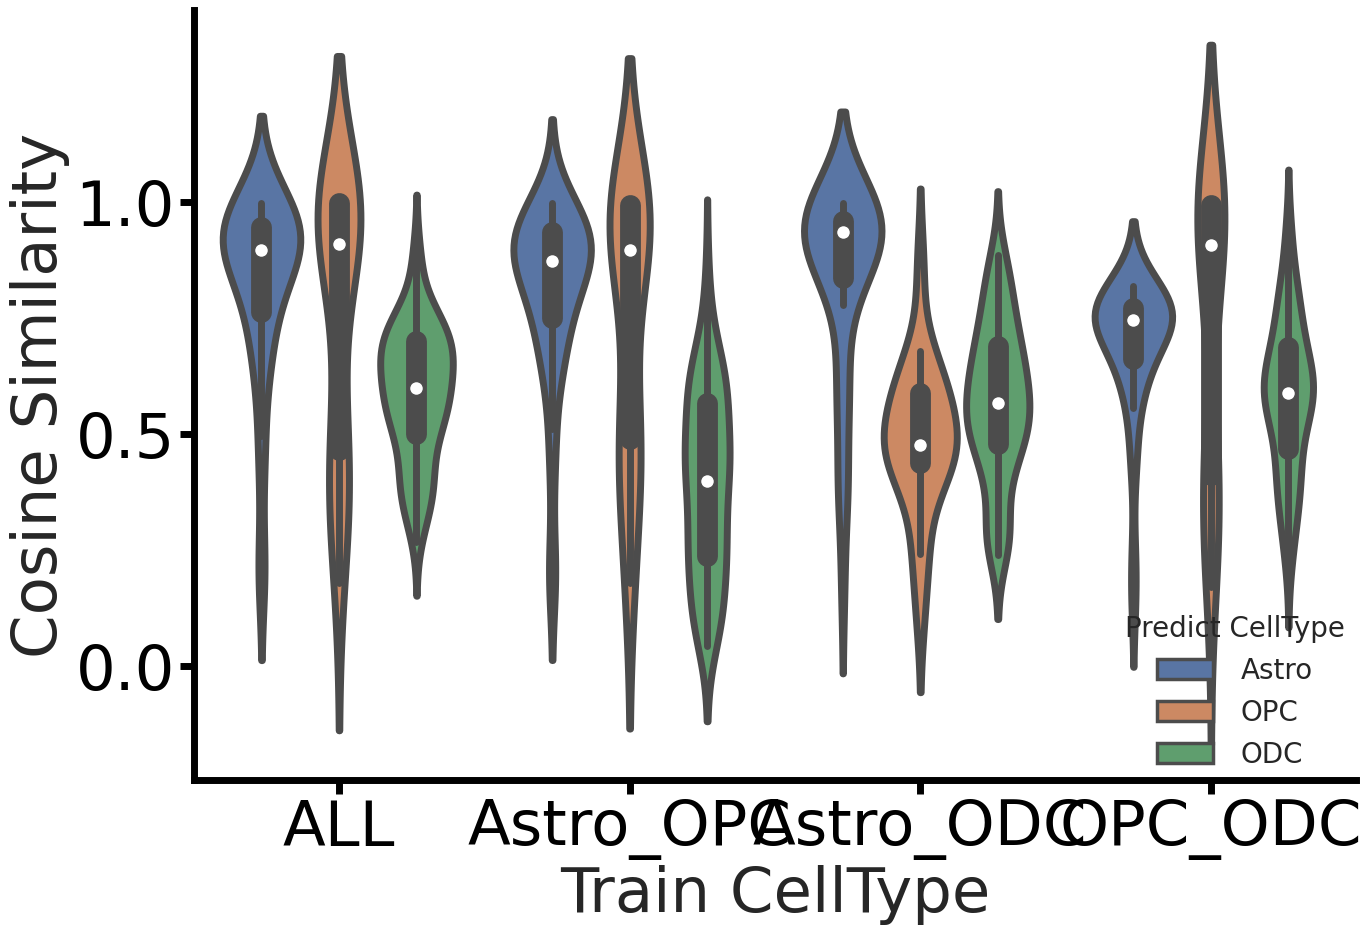

In [7]:
set_plt(figsize=(15, 10))
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

_cell_type = ['ALL', 'Astro_OPC', 'Astro_ODC', 'OPC_ODC']
_plot_values = plot_values[plot_values['model'].isin(_cell_type)]
ax = sns.violinplot(
    data=_plot_values, x='model', y='score', hue='cell_type', order=_cell_type, hue_order=['Astro', 'OPC', 'ODC'],
    linewidth=figure_size['very_small'])

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)

plt.legend(
    title='Predict CellType', title_fontsize=figure_size['middle'], fontsize=figure_size['middle'],
    facecolor='white', loc='lower right', framealpha=0, handletextpad=1, borderaxespad=0
).get_frame().set_linewidth(0.0)

plt.xlabel("Train CellType", fontsize=figure_size['ultra'])
plt.ylabel("Cosine Similarity", fontsize=figure_size['ultra'])
# plt.savefig('/lmh_data/work/SEE/analyse/figure_file/PDGFRA similarity.pdf', format='pdf', bbox_inches='tight')
plt.show()

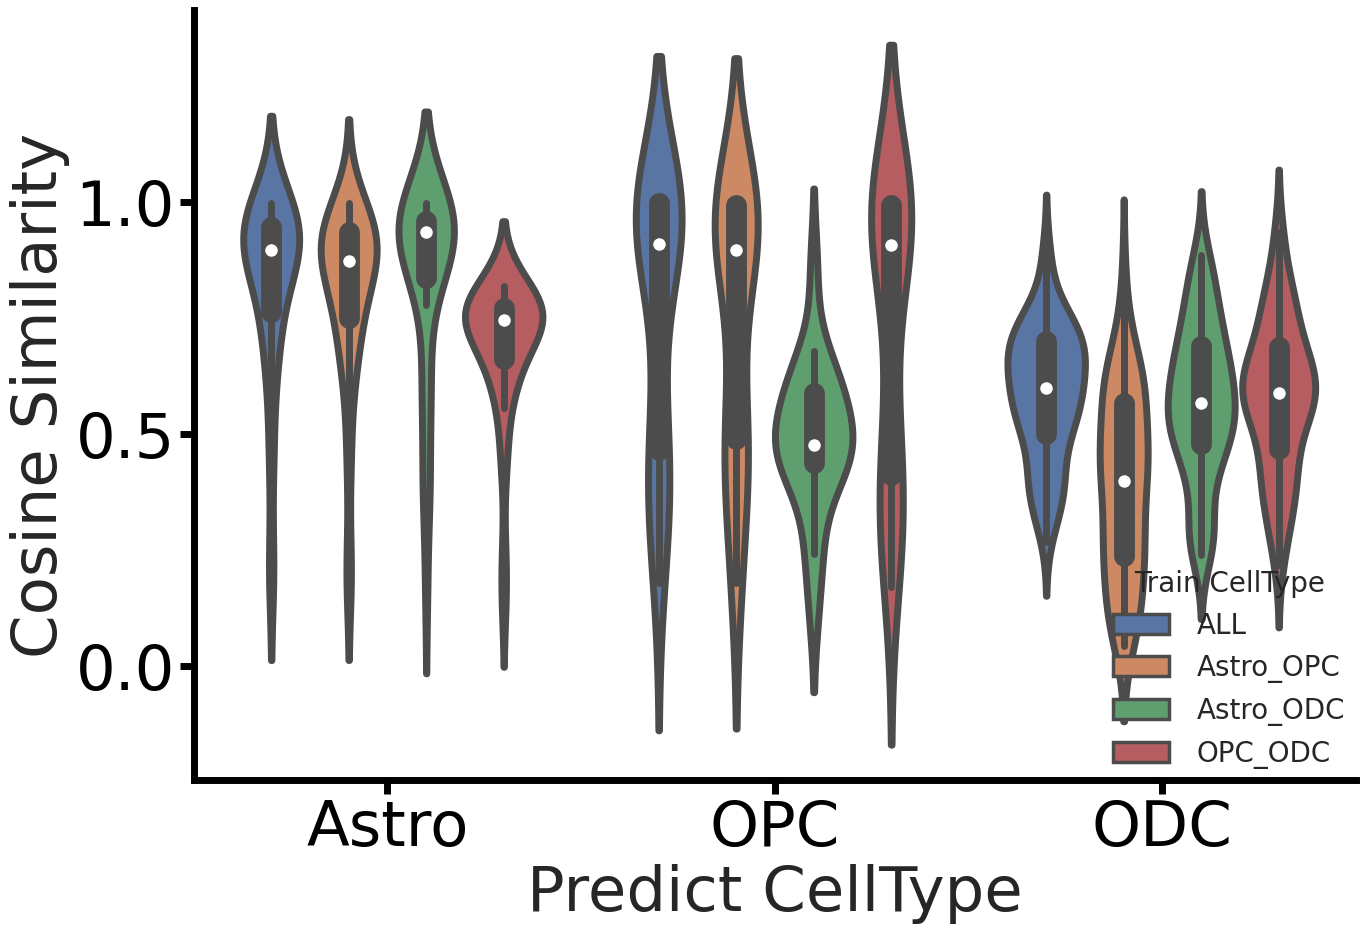

In [8]:
set_plt(figsize=(15, 10))
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

_cell_type = ['ALL', 'Astro_OPC', 'Astro_ODC', 'OPC_ODC']
_plot_values = plot_values[plot_values['model'].isin(_cell_type)]
ax = sns.violinplot(
    data=_plot_values, x='cell_type', y='score', hue='model', hue_order=_cell_type, order=['Astro', 'OPC', 'ODC'],
    linewidth=figure_size['very_small'])

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)

plt.legend(
    title='Train CellType', title_fontsize=figure_size['middle'], fontsize=figure_size['middle'],
    facecolor='white', loc='lower right', framealpha=0, handletextpad=1, borderaxespad=0
).get_frame().set_linewidth(0.0)

plt.xlabel("Predict CellType", fontsize=figure_size['ultra'])
plt.ylabel("Cosine Similarity", fontsize=figure_size['ultra'])
plt.savefig(
    '/lmh_data/work/SEE/analyse/figure_file/PDGFRA ModelGeneralization.pdf', format='pdf', bbox_inches='tight')
plt.show()